In [ ]:
#再次训练reward函数 
from collections import defaultdict
import random
import numpy as np
import time
import csv
from tqdm import tqdm
import argparse
import torch
from tqdm import tqdm
import os
import pandas as pd
tqdm.pandas()
import datetime
import argparse
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Model, GPT2PreTrainedModel
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split
import ast

In [11]:
# 读取数据
# 初始化 GPT-2 模型和 tokenizer
base_model_path = "/data/shikangwei/gptrlt/givenmodel/pretrain_model_sql"
model = GPT2Model.from_pretrained(base_model_path)
tokenizer = GPT2Tokenizer.from_pretrained(base_model_path)
config = GPT2Config.from_pretrained(base_model_path)

class GPT2RewardPredictor(nn.Module):
    def __init__(self, config):
        super(GPT2RewardPredictor, self).__init__()
        self.gpt2 = GPT2Model(config)
        self.reward_prediction_head = nn.Linear(config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # Assuming each element in batch_inputs is a tensor
        # Unpack the input tensors and make predictions for each element
        predictions = [self.predict_single(input_tensor) for input_tensor in inputs]
        # Combine the predictions into a single tensor
        predictions = torch.cat(predictions, dim=0)
        return predictions

    def predict_single(self, input_ids):
        # Assuming input_ids is a tensor of shape (batch_size, sequence_length)
        outputs = self.gpt2(input_ids)
        last_hidden_states = outputs[0]
        
        # Assuming last_hidden_states is of shape (batch_size, sequence_length, hidden_size)
        transformer_output = last_hidden_states

        # Assuming transformer_output is of shape (batch_size, sequence_length, hidden_size)
        final_step_activation = transformer_output[:, -1, :]

        # Predict reward
        reward_logits = self.reward_prediction_head(final_step_activation)
        reward_probabilities = self.sigmoid(reward_logits)

        return reward_probabilities

# 初始化模型和损失函数
classifier_model =  GPT2RewardPredictor(config)
# # Load the model
trained_model_path = "/data/shikangwei/gptrlt/model/gpt2sqlreward3"
checkpoint = torch.load(trained_model_path + "/model_checkpoint.pth")
classifier_model.load_state_dict(checkpoint['model_state_dict'])
device='cuda:0'
classifier_model.to(device)
epoch = checkpoint['epoch']
average_loss = checkpoint['average_loss']

In [4]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer

# Load the DataFrame
df = pd.read_csv("/home/shikangwei/Libs/jupyterlab/gptrlTwaf/firstgenrl1Result.csv")

In [5]:
df

,Payload,Result,Encountered_Terms_Indices
0,0'or+@<@.%0bor%0b~+{x%0b(select%0b1)}=1>(!%0b{...,0,"[15, 362, 513, 15495, 604, 16003, 807, 9508, 7..."
1,0'<@!=1.%0bor+not+true%3C(%7e+{a+1}=1)%23,0,"[15, 362, 513, 15495, 604, 16003, 642, 7724, 7..."
2,0'||%0b1<@%0bor%0b%7e+{a%0b1}=1>(!+{a+1}=1)+or%27,0,"[15, 362, 513, 15495, 604, 16003, 807, 7600, 7..."
3,0'or%0b!@<@%0b||%0b~+false=+({a+1}=1)%0bor%27,0,"[15, 362, 513, 15495, 604, 16003, 807, 9508, 7..."
4,0'or%0b1<@+or%0b!%0b{`if`+1}=1%3C(!+false)+or',0,"[15, 362, 513, 15495, 604, 16003, 807, 9508, 7..."
...,...,...,...
4027,0%27<@!=1+or%0bnot+{x%0b(select%0b1)}=1%3C(~+{...,0,"[15, 362, 513, 15495, 604, 9796, 642, 8257, 71..."
4028,0%27or%0b@<@+or%0bnot%0b0>(not+{a+1}=1)%0bor',0,"[15, 362, 513, 15495, 604, 9796, 807, 9508, 71..."
4029,0%27<@!=.1+||%0b!+{x%0b(select%0b1)}=1<(%7e%0b...,0,"[15, 362, 513, 15495, 604, 9796, 642, 9166, 71..."
4030,0'or%0b@<@+||%0bnot+{x%0b(select%0b1)}=1<({`if...,0,"[15, 362, 513, 15495, 604, 16003, 807, 9508, 7..."


In [6]:
import ast  # Safe evaluation of strings into Python expressions

# Define a function to safely evaluate the string back to a list
def string_to_list(string):
    try:
        # This is safe as `ast.literal_eval` only evaluates literals
        return ast.literal_eval(string)
    except ValueError:
        # In case the string cannot be converted to a list, return an empty list
        return []

# Apply the function to each element in the 'index' column to convert them back to lists
list_of_lists = df['Encountered_Terms_Indices'].apply(string_to_list).tolist()

# Convert the list of lists to a 2D tensor
tensor_data = torch.tensor(list_of_lists)

tensor_data

tensor([[ 15, 362, 513,  ...,   0,   0,   0],
        [ 15, 362, 513,  ...,   0,   0,   0],
        [ 15, 362, 513,  ...,   0,   0,   0],
        ...,
        [ 15, 362, 513,  ...,   0,   0,   0],
        [ 15, 362, 513,  ...,   0,   0,   0],
        [ 15, 362, 513,  ..., 657,   0,   0]])

In [7]:
tensor_all  = [tensor_data[i].unsqueeze(0) for i in range(tensor_data.size(0))]

In [9]:
# Adjust your dataset to handle tensor inputs directly
class TensorDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

# Prepare your labels as tensors
labels_tensor = torch.tensor(df["Result"].values.astype(float), dtype=torch.float32).unsqueeze(1)  # Ensure correct shape and data type

# Splitting the dataset
inputs_train, inputs_val_test, labels_train, labels_val_test = train_test_split(tensor_all, labels_tensor, test_size=0.3, random_state=42)
inputs_val, inputs_test, labels_val, labels_test = train_test_split(inputs_val_test, labels_val_test, test_size=0.5, random_state=42)

# Create datasets
train_dataset = TensorDataset(inputs_train, labels_train)
val_dataset = TensorDataset(inputs_val, labels_val)
test_dataset = TensorDataset(inputs_test, labels_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1, Average Training Loss: 0.48606719059890574
Epoch 1, Average Validation Loss: 0.358309838332628
Epoch 2, Average Training Loss: 0.34686968617894676
Epoch 2, Average Validation Loss: 0.25388646439502116
Epoch 3, Average Training Loss: 0.30105258742075286
Epoch 3, Average Validation Loss: 0.18508748082738175
Epoch 4, Average Training Loss: 0.2771181609858288
Epoch 4, Average Validation Loss: 0.1865748151352531
Average Test Loss: 0.15079070510048614


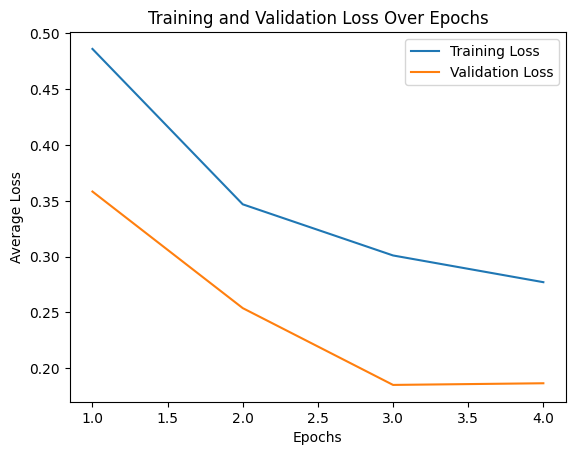

In [12]:
criterion = nn.BCELoss()
 
# 训练模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置优化器和学习率调度器
max_lr = 2e-5  # 最大学习率为2e-5
initial_lr = max_lr / 10  # 将初始学习率设置为最大学习率的十分之一
epochs = 4
total_steps = len(train_loader) * epochs
warmup_steps = total_steps // 10  # 前1/10步用于线性增长

# 定义优化器，使用非零的初始学习率
optimizer = optim.AdamW(classifier_model.parameters(), lr=initial_lr)

# 定义学习率调度器
def lr_lambda(current_step):
    if current_step < warmup_steps:
        # 线性增长到 max_lr
        return float(current_step) / float(max(1, warmup_steps)) * (max_lr / initial_lr)

    else:
        # 在预热之后，逐渐减少学习率
        return max(0.0, 1.0 - (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps)))

scheduler = LambdaLR(optimizer, lr_lambda)
classifier_model.to(device)
# 训练过程记录
training_logs = []
validation_logs = []

for epoch in range(epochs):
    classifier_model.train()
    total_loss = 0.0
    for step, (batch_inputs, batch_labels) in enumerate(train_loader):
        batch_inputs1 = [val.to(device) for val in batch_inputs]
        # Assuming batch_labels is initially of shape (batch_size, 1)
        batch_labels = batch_labels.view(-1, 1).to(device)
        predictions = classifier_model(batch_inputs1)
        
        optimizer.zero_grad() 
        # Rest of your code for computing and backpropagating the loss
        loss = criterion(predictions, batch_labels)
        loss.backward()        
        optimizer.step()
        total_loss += loss.item()
        # 学习率线性增长和退火
        scheduler.step()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Training Loss: {average_loss}")
    
    # Validation
    classifier_model.eval()
    val_total_loss = 0.0
    with torch.no_grad():
        for val_step, (val_batch_inputs, val_batch_labels) in enumerate(val_loader):
            val_batch_inputs = [val.to(device)  for val in val_batch_inputs]
            val_batch_labels = val_batch_labels.view(-1, 1).to(device)
            val_predictions = classifier_model(val_batch_inputs)
            val_loss = criterion(val_predictions, val_batch_labels)
            val_total_loss += val_loss.item()

    average_val_loss = val_total_loss / len(val_loader)
    print(f"Epoch {epoch + 1}, Average Validation Loss: {average_val_loss}")

    # 记录训练和验证过程
    training_logs.append({"Epoch": epoch + 1, "Average Loss": average_loss})
    validation_logs.append({"Epoch": epoch + 1, "Average Loss": average_val_loss})

# Test Evaluation
classifier_model.eval()
test_total_loss = 0.0
with torch.no_grad():
    for test_step, (test_batch_inputs, test_batch_labels) in enumerate(test_loader):
        test_batch_inputs =[val.to(device) for val in test_batch_inputs]
        test_batch_labels = test_batch_labels.view(-1, 1).to(device)
        test_predictions = classifier_model(test_batch_inputs)
        test_loss = criterion(test_predictions, test_batch_labels)
        test_total_loss += test_loss.item()

average_test_loss = test_total_loss / len(test_loader)
print(f"Average Test Loss: {average_test_loss}")

# Plotting the training and validation losses
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, [log["Average Loss"] for log in training_logs], label='Training Loss')
plt.plot(epochs_range, [log["Average Loss"] for log in validation_logs], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [13]:
trained_model_path = "/data/shikangwei/gptrlt/model/gpt2sqlreward4"
# Save the state_dict along with other necessary information
torch.save({
    'epoch': epoch,
    'model_state_dict': classifier_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'average_loss': average_loss
}, trained_model_path + "/model_checkpoint.pth")